In [8]:
import numpy as np
import matplotlib.pyplot as plt

import gpcg

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator
from scipy.io import loadmat

import math



from PIL import Image, ImageOps, ImageFilter, ImageDraw, ImageFont

from csias import CSIASSolver1D

# Load data

In [12]:
mat = loadmat('GOTCHA_PFA_data.mat')
tmp = mat['phdata']

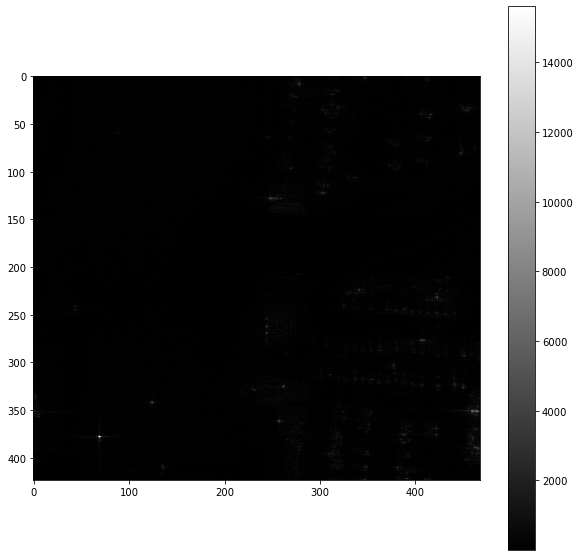

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(np.fft.fft2(tmp)), cmap="gray")
plt.colorbar()
plt.show()

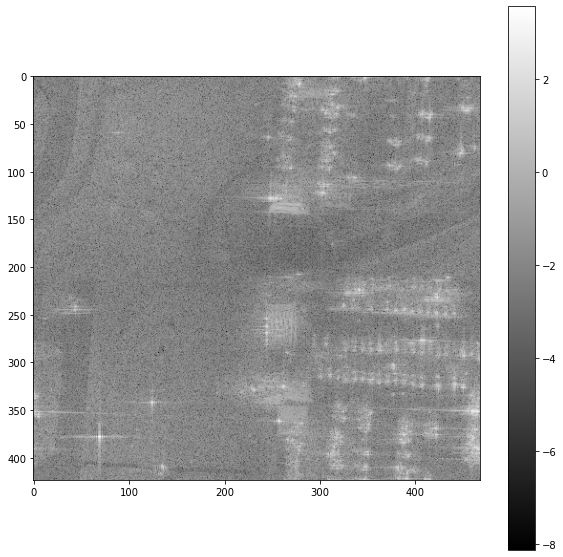

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(np.fft.fft2(tmp, norm="ortho"))), cmap="gray")
plt.colorbar()
plt.show()

In [21]:
noisy_obs = tmp.copy()
noise_sigma = 0.01

# With R a gradient operator

# Try the solver

In [22]:
class CSIASSolver2D:

    def __init__(self, y, R, noise_sigma=1.0):

        self.y = y
        self.R = R
        self.noise_sigma = noise_sigma
        self.grid_shape = y.shape
        self.n = math.prod(self.grid_shape)

        # Compute MAP phase
        self.map_phase = np.angle(np.fft.ifft2(y, norm="ortho"))

        # RHS vec
        tmp = (1/(self.noise_sigma**2))*np.exp(-1j*self.map_phase)*np.fft.ifft2(y, norm="ortho")
        self.rhs_vec = np.real( tmp + tmp.conj() )
        self.rhs_vec_flat = self.rhs_vec.flatten()


    def solve_with_tikhonov(self, reg_lambda=1, cg_maxits=100, cg_tol=1e-3):
        """Solves the problem using Tikhonov regularization on the magnitude."""
        
        # Make coefficient matrix
        coeff_mat = (reg_lambda*(self.R.T @ self.R)) + aslinearoperator( (2/(self.noise_sigma**2))*sps.eye(self.n) )

        # Solve bound-constrained problem using GPCG
        lower_bounds = np.zeros(coeff_mat.shape[0])
        upper_bounds = np.inf*np.ones(coeff_mat.shape[0])
        gpcg_solver = gpcg.GPCGSolver(coeff_mat, self.rhs_vec_flat, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
        gpcg_solve = gpcg_solver.solve(maxits=cg_maxits, tol=cg_tol)
        gpcg_sol = gpcg_solve["x"]
        gpcg_sol = gpcg_sol.reshape(self.grid_shape)

        data = {
            "magnitude": gpcg_sol,
            "phase": self.map_phase,
        }

        return data
    


    def solve_with_ias(self, hyperparameters, n_iterations=20):
        """Solves the problem using the IAS method."""

        # Initialization
        magnitude = np.ones(self.n)
        beta = np.ones(self.R.shape[0])
        
        for j in range(n_iterations):
            
            # Update r
            magnitude = self.ias_magnitude_update(beta, prev_magnitude=magnitude)

            # Update beta
            beta = self.ias_beta_update(magnitude, hyperparameters)

        data = {
            "magnitude": magnitude.reshape(self.grid_shape),
            "phase": self.map_phase,
            "beta": beta,
        }

        return data



    def ias_magnitude_update(self, beta, prev_magnitude=None, cg_maxits=100, cg_tol=1e-3):
        """Computes the magnitude update for fixed beta."""

        # Make coefficient matrix
        coeff_mat = (self.R.T @ aslinearoperator( sps.diags(1.0/beta) )  @ self.R) + aslinearoperator( (2/(self.noise_sigma**2))*sps.eye(self.n) )

        # Solve bound-constrained problem using GPCG
        lower_bounds = np.zeros(coeff_mat.shape[0])
        upper_bounds = np.inf*np.ones(coeff_mat.shape[0])
        gpcg_solver = gpcg.GPCGSolver(coeff_mat, self.rhs_vec_flat, lower_bounds=lower_bounds, upper_bounds=upper_bounds)
        gpcg_solve = gpcg_solver.solve(x0=prev_magnitude, maxits=cg_maxits, tol=cg_tol)
        gpcg_sol = gpcg_solve["x"]

        return gpcg_sol



    def ias_beta_update(self, magnitude, hyperparameters):
        """Computes the beta update for fixed magnitude."""

        # Hyper-prior parameters
        r, s, vartheta = hyperparameters["r"], hyperparameters["s"], hyperparameters["vartheta"]
        
        assert (r == -1) or (r == 1), "Currently only supporting r = -1 or r = 1."

        if r == 1:

            eta = (r*s) - 1.5
            Rx = self.R @ magnitude

            root_term = (eta**2) + (4/vartheta)*( 0.5*(Rx**2)  )
            new_beta = (vartheta/2)*(  eta + np.sqrt(root_term)   ) 

            return new_beta 
          
        else:

            eta = (r*s) - 1.5
            eta = -1*eta
            Rx = self.R @ magnitude
            new_beta = (  vartheta + 0.5*(Rx**2)  )/eta

            return new_beta

In [19]:
# Set up regularization matrix
def build_1d_first_order_grad(N: int, boundary: str = "periodic"):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "periodic", "zero"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=-1)
    #d_mat = sps.csc_matrix(d_mat)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[0,-1] = -1
    elif boundary == "zero":
        pass
    elif boundary == "none":
        d_mat = d_mat[1:,:]
    else:
        pass
    
    return d_mat


def build_2d_first_order_grad(M: int, N: int, boundary = "zero"):
    """Constructs a SciPy sparse matrix that extracts the discrete gradient of an input image.
    Assumes periodic BCs. Input image should have original dimension (M,N), must be flattened
    to compute matrix-vector product. First set is horizontal gradient, second is vertical.
    """

    # Construct our differencing matrices
    d_mat_horiz = build_1d_first_order_grad(N, boundary=boundary)
    d_mat_vert = build_1d_first_order_grad(M, boundary=boundary)
    
    # Build the combined matrix
    eye_vert = sps.eye(M)
    d_mat_one = sps.kron(eye_vert, d_mat_horiz)
    
    eye_horiz = sps.eye(N)
    d_mat_two = sps.kron(d_mat_vert, eye_horiz)

    full_diff_mat = sps.vstack([d_mat_one, d_mat_two])
    
    return full_diff_mat


In [23]:
# Set up regularization R
img_shape = tmp.shape
M, N = img_shape
R = build_2d_first_order_grad(M, N, boundary="none")
R = aslinearoperator(R)

# Set up solver
solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)

In [39]:
# Tikhonov solution
reg_lambda = 1e4
data = solver.solve_with_tikhonov(reg_lambda=reg_lambda, cg_maxits=300, cg_tol=1e-3)

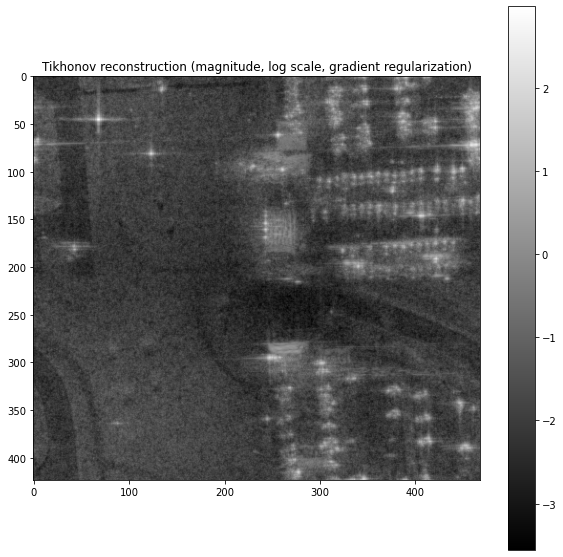

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")
plt.colorbar()
plt.title("Tikhonov reconstruction (magnitude, log scale, gradient regularization)")
plt.show()

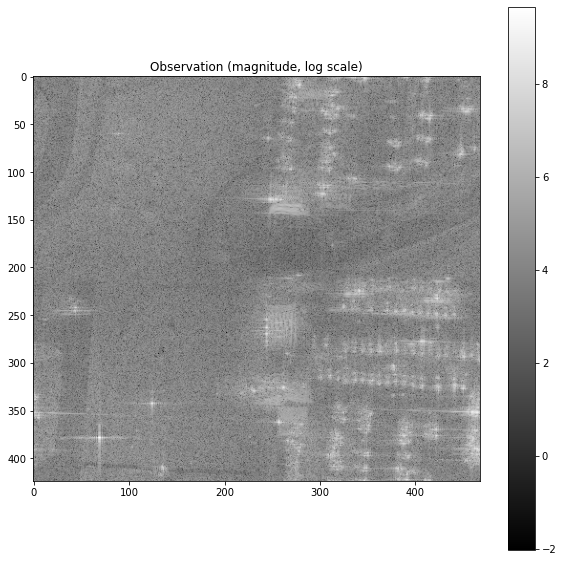

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(np.fft.fft2(tmp))), cmap="gray")
plt.colorbar()
plt.title("Observation (magnitude, log scale)")
plt.show()

### Nonconvex IAS

In [48]:
# Hyper-prior parameters
hyperparameters = {
    "r": 1,
    "s": 1.5 + 1e-3,
    "vartheta": 1e-4,
}

csias_solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=20)

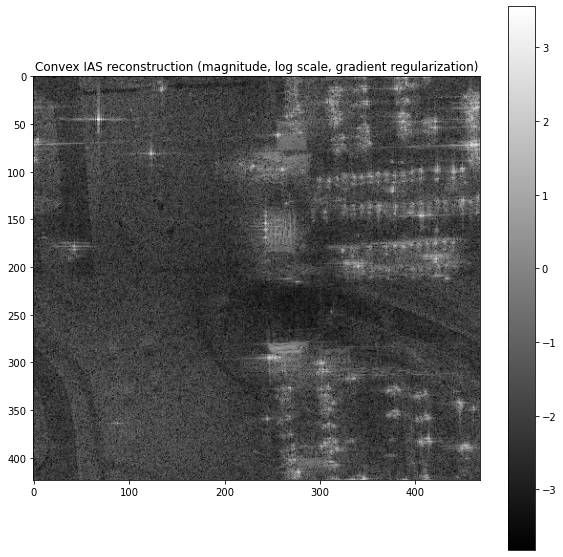

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")
plt.colorbar()
plt.title("Convex IAS reconstruction (magnitude, log scale, gradient regularization)")
plt.show()

# Sparsity regularization

In [50]:
# Set up regularization R
img_shape = tmp.shape
M, N = img_shape
R = sps.eye(M*N)
R = aslinearoperator(R)

# Set up solver
solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)

In [55]:
# Tikhonov solution
reg_lambda = 1e8
data = solver.solve_with_tikhonov(reg_lambda=reg_lambda, cg_maxits=300, cg_tol=1e-3)

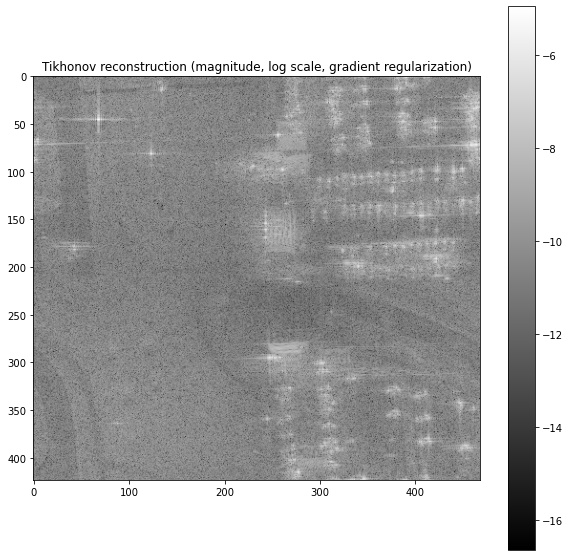

In [56]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")
plt.colorbar()
plt.title("Tikhonov reconstruction (magnitude, log scale, gradient regularization)")
plt.show()

In [61]:
# Hyper-prior parameters
hyperparameters = {
    "r": -1,
    "s": 1,
    "vartheta": 1e-6,
}

csias_solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=40)

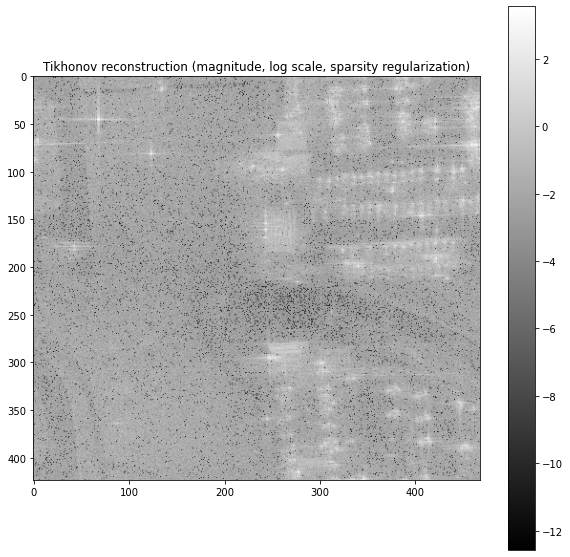

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")
plt.colorbar()
plt.title("Tikhonov reconstruction (magnitude, log scale, sparsity regularization)")
plt.show()

In [64]:
# Hyper-prior parameters
hyperparameters = {
    "r": 1,
    "s": 1.5 + 1e-3,
    "vartheta": 1e-6,
}

csias_solver = CSIASSolver2D(noisy_obs, R, noise_sigma=noise_sigma)
data = csias_solver.solve_with_ias(hyperparameters=hyperparameters, n_iterations=20)

/var/folders/8y/4mq6cs_x20j1gp06wytwhlwm0000gn/T/ipykernel_69756/2529829763.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")


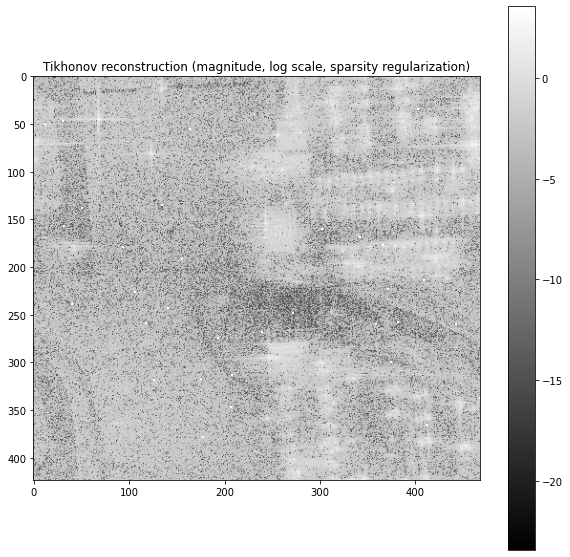

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(np.flip(np.log(np.abs(data["magnitude"])), axis=1), cmap="gray")
plt.colorbar()
plt.title("Tikhonov reconstruction (magnitude, log scale, sparsity regularization)")
plt.show()